In [25]:
!pip install pandas scikit-learn

In [26]:
# imports
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

# **Assignment 3 - Dataset 1: Regression**

Group: #45

Isaac Lafond - 300191954

**Introduction:**

This notebook overview steps for a predictive analysis of house prices based on the dataset detailed below. The steps required in achieving the predictive analysis are broken down in sections with text and code block describing the step in question. Executing this notebook will show the results of the code blocks which implement the steps of the predictive analysis.

**Dataset Description:**

This dataset by Den Kuznetz, contains features which can affect the value of a property for the pupose of predicting property value based on these features. It contains several attributes such as square footage, the number of bedrooms, bathrooms, floors, the year the prpoperty was built, whether the property has a garden or pool, the size of the garage, the location score and the distance from the city center. The size values such as square footage and garage size are measured in square meters and the distance to center is measured in kilometers. The garden and pool indicator is shown as 1 for yes and 0 for no. Finally, the location score is a score from 0 to 10 indicating the quality of the neighbourhood (higher = better).

## **Regression Empirical Study**

In [27]:
df = pd.read_csv("https://raw.githubusercontent.com/IsaacLafond/CSI-4142---Fundamentals-of-Data-Science/main/Assignment%203/datasets/real_estate_dataset.csv")

### **a) Cleaning the data**

Here we apply checks for the presence of errors that would require cleaning/imputation.

True = all values pass the check

False = not all values pass the check

\* unless indicated diffrently in the results output

In [28]:
# 1 - Data type check

# iterate over each column in the dataframe df and ensure that each value in the column is of the correct data type
for column in df.columns:
  column_type = df[column].dtype
  print(f"{column}: {df[column].apply(lambda x: type(x) == column_type).all()}")

ID: True
Square_Feet: True
Num_Bedrooms: True
Num_Bathrooms: True
Num_Floors: True
Year_Built: True
Has_Garden: True
Has_Pool: True
Garage_Size: True
Location_Score: True
Distance_to_Center: True
Price: True


In [29]:
# 2 - Range check
# Create numrange class with min and max and default is infinite range
# define contains functions so that "in" check return true in between min and max
class NumRange:
  def __init__(self, min=float('-inf'), max=float('inf')):
    self.min = min
    self.max = max
  def __contains__(self, x):
    return self.min <= x <= self.max

# parameters = column name: expected range
params = {
    'ID': NumRange(1, 500),
    'Square_Feet': NumRange(),
    'Num_Bedrooms': NumRange(),
    'Num_Bathrooms': NumRange(),
    'Num_Floors': NumRange(),
    'Year_Built': NumRange(0, 2025),
    'Has_Garden': NumRange(0, 1),
    'Has_Pool': NumRange(0, 1),
    'Garage_Size': NumRange(),
    'Location_Score': NumRange(0, 10),
    'Distance_to_Center': NumRange(),
    'Price': NumRange()
}

# iterate over each column and very that each value in the column is withing the given range in params
for column in df.columns:
  print(f"{column}: {df[column].apply(lambda x: x in params[column]).all()}")

ID: True
Square_Feet: True
Num_Bedrooms: True
Num_Bathrooms: True
Num_Floors: True
Year_Built: True
Has_Garden: True
Has_Pool: True
Garage_Size: True
Location_Score: True
Distance_to_Center: True
Price: True


In [30]:
# 3 - Format check
# regex for an integer of any number
integer_regex = '^\d+$'
# regex for any floating point number
float_regex = '^\d+\.\d+$'
# regex for integer that is binary that is can only be 0 or 1
binary_regex = '^(0|1)$'
# regex for a year list as YYYY that cant be more than 2025
year_regex = '^\d{4}$'

# parameters = column name: expected pattern
params = {
    'ID': integer_regex,
    'Square_Feet': float_regex,
    'Num_Bedrooms': integer_regex,
    'Num_Bathrooms': integer_regex,
    'Num_Floors': integer_regex,
    'Year_Built': year_regex,
    'Has_Garden': binary_regex,
    'Has_Pool': binary_regex,
    'Garage_Size': integer_regex,
    'Location_Score': float_regex,
    'Distance_to_Center': float_regex,
    'Price': float_regex
}

# iterate over each column in the dataframe and ensure each value matches the corresponding regex in param
for column in df.columns:
  # check if each value in the column matches the regex in params
  print(f"{column}: {df[column].astype(str).str.match(params[column]).all()}")

ID: True
Square_Feet: True
Num_Bedrooms: True
Num_Bathrooms: True
Num_Floors: True
Year_Built: True
Has_Garden: True
Has_Pool: True
Garage_Size: True
Location_Score: True
Distance_to_Center: True
Price: True


In [31]:
# 4 - Consistency check

"""
In this dataset none of the columns are logically linked.
Therefore a consistency check is not needed.
"""
pass

In [32]:
# 5 - Uniqueness check
# check for uniqueness in values which are identifier
# This dataset does not have email of usernames and ID is the only identfier
# therefore id should have 500 unique values

# define any int class for comparison that is always true
class AnyNum:
  def __eq__(self, x):
    return True
any_num = AnyNum()

# parameter = column name: number of expected unique values
params = {
    'ID': 500,
    'Square_Feet': any_num,
    'Num_Bedrooms': any_num,
    'Num_Bathrooms': any_num,
    'Num_Floors': any_num,
    'Year_Built': any_num,
    'Has_Garden': any_num,
    'Has_Pool': any_num,
    'Garage_Size': any_num,
    'Location_Score': any_num,
    'Distance_to_Center': any_num,
    'Price': any_num
}

# iterate over each column and print the number of unique values in the column
for column in df.columns:
  print(f"{column}: {df[column].nunique() == params[column]}")

ID: True
Square_Feet: True
Num_Bedrooms: True
Num_Bathrooms: True
Num_Floors: True
Year_Built: True
Has_Garden: True
Has_Pool: True
Garage_Size: True
Location_Score: True
Distance_to_Center: True
Price: True


In [33]:
# 6 - Presence check

# iterate over each column and verify that all values arent empty
for column in df.columns:
  print(f"{column}: {df[column].notnull().any()}")

ID: True
Square_Feet: True
Num_Bedrooms: True
Num_Bathrooms: True
Num_Floors: True
Year_Built: True
Has_Garden: True
Has_Pool: True
Garage_Size: True
Location_Score: True
Distance_to_Center: True
Price: True


In [34]:
# 7 - Length check
# define a length range class to verify if length is in expected range
class LengthRange:
  def __init__(self, min=0, max=float('inf')):
    self.min = min
    self.max = max
  def __contains__(self, x):
    return self.min <= len(x) <= self.max
any_length = LengthRange()

# parameters = column name: expected value length
params = {
    'ID': LengthRange(1, 3),
    'Square_Feet': any_length,
    'Num_Bedrooms': any_length,
    'Num_Bathrooms': any_length,
    'Num_Floors': any_length,
    'Year_Built': LengthRange(4, 4),
    'Has_Garden': LengthRange(1, 1),
    'Has_Pool': LengthRange(1, 1),
    'Garage_Size': any_length,
    'Location_Score': any_length,
    'Distance_to_Center': any_length,
    'Price': any_length
}

# iterate over each column and very that each value in the column is withing the given length range in params
for column in df.columns:
  print(f"{column}: {df[column].astype(str).apply(lambda x: x in params[column]).all()}")

ID: True
Square_Feet: True
Num_Bedrooms: True
Num_Bathrooms: True
Num_Floors: True
Year_Built: True
Has_Garden: True
Has_Pool: True
Garage_Size: True
Location_Score: True
Distance_to_Center: True
Price: True


In [35]:
# 8 - Look-up check
# this check verifies that all the values are in the allowed set of values for that column
# for this test the only columns with a defined list of acceptable values is Has_Garden and Has_Pool (and IDs from 1-500)
# define any list that always contains the value you verify
class AnyList:
  def __contains__(self, x):
    return True
any_list = AnyList()

# parameters = column name: list of accepted values
params = {
    'ID': range(1, 501),
    'Square_Feet': any_list,
    'Num_Bedrooms': any_list,
    'Num_Bathrooms': any_list,
    'Num_Floors': any_list,
    'Year_Built': any_list,
    'Has_Garden': [0, 1],
    'Has_Pool': [0, 1],
    'Garage_Size': any_list,
    'Location_Score': any_list,
    'Distance_to_Center': any_list,
    'Price': any_list
}

# iterate over each column and verify each of its values are in the list of acceptable values
for column in df.columns:
  print(f"{column}: {df[column].apply(lambda x: x in params[column]).all()}")

ID: True
Square_Feet: True
Num_Bedrooms: True
Num_Bathrooms: True
Num_Floors: True
Year_Built: True
Has_Garden: True
Has_Pool: True
Garage_Size: True
Location_Score: True
Distance_to_Center: True
Price: True


In [36]:
# 9 - Exact duplicate check

# check for any exact duplicates in the dataset
print(f"Presence of exact duplicates: {df.duplicated().any()}")

# No exact duplicatesd found so do the same things ignoring the id column
df_no_id = df.drop('ID', axis=1, inplace=False)
print(f"Presence of exact duplicates (omiting ID): {df.duplicated().any()}")

Presence of exact duplicates: False
Presence of exact duplicates (omiting ID): False


In [37]:
# 10 - Near duplicate check
def close_enough(x, y, tolerance=0.001):
  return abs(x - y) <= tolerance

# is near duplicate function
def near_duplicate(row, df, check_columns, params):
  for _, other_row in df.iterrows():
    if not row.equals(other_row):
      # check that all are nearly identical
      if all(close_enough(row[column], other_row[column], params[column]) for column in check_columns):
        result = True # found a match return true
  return False # no matches found return false


# identical columns
identical_columns = ['Num_Bedrooms', 'Num_Bathrooms', 'Num_Floors', 'Year_Built', 'Has_Garden', 'Has_Pool']

# nearly identical columns
nearly_identical_columns = ['ID', 'Square_Feet', 'Garage_Size', 'Location_Score', 'Distance_to_Center', 'Price']
# params = column name: acceptable difference threshold
params = {
    'ID': float('inf'),
    'Square_Feet': 0.5,
    'Num_Bedrooms': 0,
    'Num_Bathrooms': 0,
    'Num_Floors': 0,
    'Year_Built': 0,
    'Has_Garden': 0,
    'Has_Pool': 0,
    'Garage_Size': 1,
    'Location_Score': 0.5,
    'Distance_to_Center': 0.5,
    'Price': 5
}

# return new df dropping the id, square feet, garage size garage size, location score, distance to center and price
mask = df.duplicated(subset=identical_columns, keep=False)
df[mask]

near_dupes = df[mask].apply(lambda x: near_duplicate(x, df[mask], nearly_identical_columns, params), axis=1)
print(f"Presence of near duplicates: {near_dupes.any()}")

Presence of near duplicates: False


As we can see, based on the above test. This dataset is clean and won't require imputation based on these checks.

### **b) Categorical feature encoding**

In this dataset, each value is a numerical value with the only exceptions being Has_Pool and Has_Garden. As these values are categorical, they're the only columns which would require one-hot encoding in order to be used in linear regression. However, this dataset has already one-hot encoded these values where the value yes is represented by 1 and no is represented by 0 (example: yes this house has a pool means Has_Pool=1) meaning additional encoding is not necessary for this dataset.

### **c) EDA and Outlier detection**

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'Square_Feet'}>,
        <Axes: title={'center': 'Num_Bedrooms'}>],
       [<Axes: title={'center': 'Num_Bathrooms'}>,
        <Axes: title={'center': 'Num_Floors'}>,
        <Axes: title={'center': 'Year_Built'}>],
       [<Axes: title={'center': 'Has_Garden'}>,
        <Axes: title={'center': 'Has_Pool'}>,
        <Axes: title={'center': 'Garage_Size'}>],
       [<Axes: title={'center': 'Location_Score'}>,
        <Axes: title={'center': 'Distance_to_Center'}>,
        <Axes: title={'center': 'Price'}>]], dtype=object)

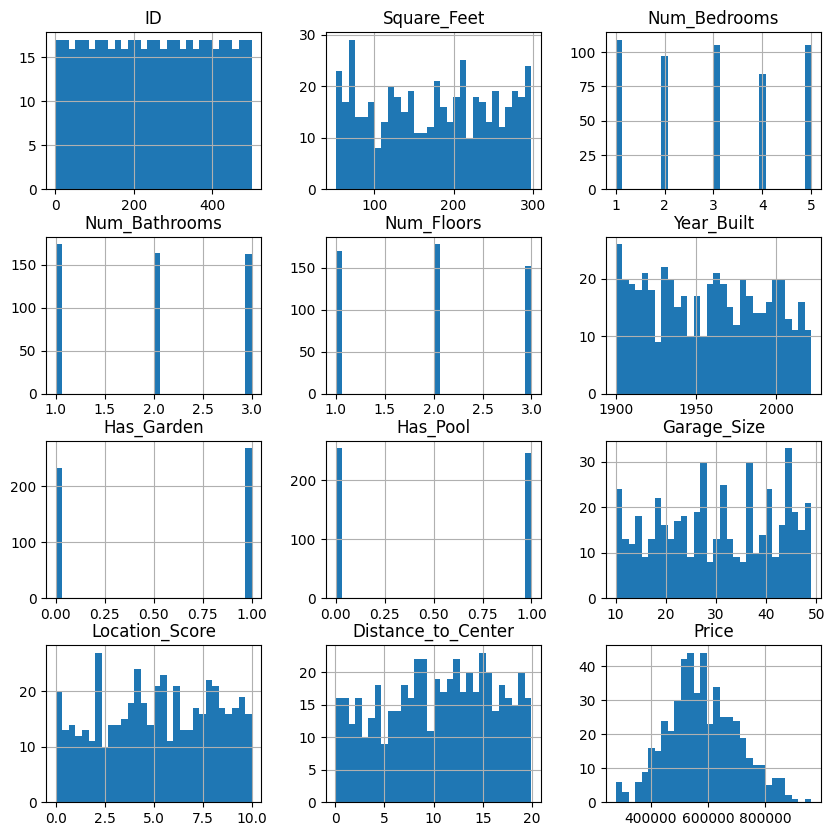

In [38]:
# Create histogram plots for each dataset feature
df.hist(bins=30, figsize=(10, 10)) # [1]

Based on the histograms above, we can immediately rule out the ID column for LOF as all its value are unique. We can rule out applying LOF on Num_Bedrooms, Num_Bathrooms, Num_Floors,  Has_Garden and Has_Pool due to their limited values and their even distibution. Finally, each of the remaining features could benefit from LOF.

array([[<Axes: title={'center': 'Square_Feet'}>,
        <Axes: title={'center': 'Year_Built'}>],
       [<Axes: title={'center': 'Garage_Size'}>,
        <Axes: title={'center': 'Location_Score'}>],
       [<Axes: title={'center': 'Distance_to_Center'}>,
        <Axes: title={'center': 'Price'}>]], dtype=object)

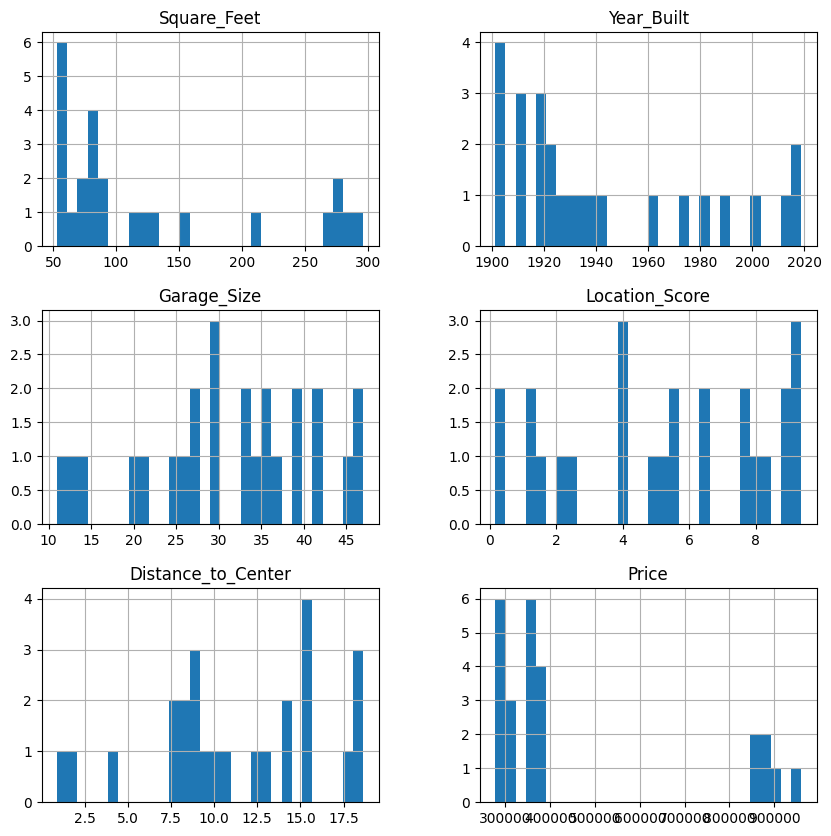

In [46]:
# LOC implementation [3]
# select the subset of rows to take into account
LOC_subset = ['Square_Feet', 'Year_Built', 'Garage_Size', 'Location_Score', 'Distance_to_Center', 'Price']
# create a copy of the dataframe containing only the selected columns
df_loc = df[LOC_subset].copy() # [2]

# fit and predict LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05) # 20 neighbours and 5% contamination
df_loc['LOF_Outliers'] = lof.fit_predict(df_loc)

# map 1 to False not an outlier and -1 to True is an outlier to use as mask
df_loc['LOF_Outliers'] = df_loc['LOF_Outliers'].map({1: False, -1: True})

# Show histograms of values identified as outliers
df_loc[df_loc['LOF_Outliers']].hist(bins=30, figsize=(10, 10))

### **d) Predictive analysis: Linear Regression**

In [40]:
# Implement a basic Linear Regression base model [4]
# temporary copy of the dataframe
df_temp = df.copy()
# create the axis
X = df_temp.drop('Price', axis=1)
y = df_temp['Price']

baseline_model = LinearRegression()
baseline_scores = cross_val_score(baseline_model, X, y, cv=4, scoring='r2')

# print the computed scores
print("Baseline R2 Score:", baseline_scores.mean())

Baseline R2 Score: 0.9744001290767969


### **e) Feature Engineering**

The resulting R2 score for the baseline model already shows great results let's see if adding some features can boost this performance.

In [41]:
# Create additional features

def feature_engineering(df):
  # add a house age column
  df['House_Age'] = 2025 - df['Year_Built']
  # add a rooms to floor ratio
  df['Rooms_to_Floors'] = df['Num_Bedrooms'] + df['Num_Bathrooms'] / df['Num_Floors']
  # add a location adjusted square footage
  df['Square_Feet_Value'] = df['Square_Feet'] * df['Location_Score']
  return df

### **f) Empirical study**

In [48]:
# Empirical study

# 4-fold cross validation evaluation
def evaluate_model(model, X, y):
  scores = cross_val_score(model, X, y, cv=4, scoring='r2')
  return scores.mean()

# split the dataset (train, validate and test)
train_val, test = train_test_split(df_temp, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42) # 0.25 * 0.8 = 20%

# Extract variable
X_train = train.drop('Price', axis=1)
y_train = train['Price']
X_val = val.drop('Price', axis=1)
y_val = val['Price']
X_test = test.drop('Price', axis=1)
y_test = test['Price']

# define variable after LOF
outliers = df_loc['LOF_Outliers']
train_no_outliers = train[~outliers]
X_train_no_outliers = train_no_outliers.drop('Price', axis=1)
y_train_no_outliers = train_no_outliers['Price']

# define variable after feature engineering
X_train_eng = feature_engineering(X_train.copy())
X_val_eng = feature_engineering(X_val.copy())
X_test_eng = feature_engineering(X_test.copy())

# define variable after LOF and feature engineering
X_train_both = feature_engineering(X_train_no_outliers.copy())
X_val_both = feature_engineering(X_val)

# define model
model = LinearRegression()

# baseline model
baseline_score = evaluate_model(model, X_train, y_train)
print("Baseline R2 Score:", baseline_score)
# outliers removed
lof_score = evaluate_model(model, X_train_no_outliers, y_train_no_outliers)
print("LOF R2 Score:", lof_score)
# feature engineering
eng_score = evaluate_model(model, X_train_eng, y_train)
print("Feature Engineering R2 Score:", eng_score)
# both outliers removed and feature engineering
both_score = evaluate_model(model, X_train_both, y_train_no_outliers)
print("Both R2 Score:", both_score)

Baseline R2 Score: 0.9749017343702869
LOF R2 Score: 0.9687481258126146
Feature Engineering R2 Score: 0.9750365624108964
Both R2 Score: 0.9687794001612694


<ipython-input-48-2185e14e97ac>:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_no_outliers = train[~outliers]


In [49]:
# final test for best performing configuration
best_model = model.fit(X_train_eng, y_train)
test_score = best_model.score(X_test_eng, y_test)
print("Test R2 Score:", test_score)

Test R2 Score: 0.9707683215424074


### **g) Result analysis**

Observing the results we see the baseline model showing similar performance to the performance seen in step d). When looking at the results of training the model whitout accounting the outliers, we see a slight dip in performance compared to the base model. This may be due to training the model on a an ideal set of data leading to poor results on "unideal" datapoints bringing down the score. Looking at the feature engineering results, we see a slight improvement in predictions performance while combining feature engineering with LOF sees similar performance decrease. The added context of additional engineered features seems to improve the performance and the model and produce the best results.

##**Conclusion**

In conclusion, this assignment overviewed the steps necessary to conduct a predictive analysis. Each step from data cleaning, encoding, EDA and outliers management and feature engineering is crucial for achieving good results such as the 97% accuracy achieved in this experiement.

## **References**

Outside of the references listed below, most code found in this notebook is the result of AI code suggestions provided by default in GoogleColab based on the comments listes and fine tune with method descriptions and documentation of the methods to achieve the desired result.

[1] https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html

[2] https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html

[3] ChatGPT: Prompt = "Can you help me implement Local Outlier Factor (LOF) on the attached dataset? \*The dataset was attached as part of the prompt\*

[4] ChatGPT: Prompt = "Can you help me implement a baseline linear regression model that predicts the house prices?"